# AWIPEV overflights
The [AWIPEV Base](https://www.awipev.eu/) is a French-German Arctic Research Base at Ny-Ålesund, Svalbard, operated by the German Alfred Wegener Institute for Polar and Marine Research (AWI) and the French Polar Institute Paul Emile Victor (IPEV). At AWIPEV's [Atmosphere Observatory](https://www.awipev.eu/awipev-observatories/atmosphere-observatory/) long-term observations of atmospheric thermodynamics, clouds, aerosols and trace gases are collected using various in-situ and remote sensing instrumentation.

To make use of the synergy between airborne and ground-based observations, Polar5 and Polar6 frequently overpassed the AWIPEV Base. The `flight-phase-separation` allows for a quick filtering of Ny-Ålesund overflights using the keywords listed under the `kinds` parameter of each segment. The use of the keyword will be presented here. Additionally, we will calculate the duration, Polar5 was within 15 km of AWIPEV for each research flight.

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import ac3airborne
plt.style.use("../mplstyle/book")

At first we load the flight-phase separation and the intake catalog.

In [2]:
meta = ac3airborne.get_flight_segments()
cat = ac3airborne.get_intake_catalog()

## Flights near AWIPEV Base
With the help of meta information stored in `flight-phase-separation`, we can find the flights, which overpassed the AWIPEV Base.

In [3]:
for flight_id, flight in meta['P5'].items():
        
    awipev_remark = [event for event in flight['events'] 
                     if 'Ny-Alesund' in event]
    
    if len(awipev_remark) > 0:
        print(f'{flight_id}: {awipev_remark}')

ACLOUD_P5_RF04: ['Ny-Alesund overflight']
ACLOUD_P5_RF05: ['Ny-Alesund overflight']
ACLOUD_P5_RF08: ['Ny-Alesund overflight']
ACLOUD_P5_RF10: ['Ny-Alesund overflight']
ACLOUD_P5_RF11: ['Ny-Alesund overflight with cross pattern']
ACLOUD_P5_RF14: ['Ny-Alesund overflight with cross pattern']
ACLOUD_P5_RF18: ['Ny-Alesund overflight with cross pattern']
ACLOUD_P5_RF19: ['Ny-Alesund overflight with cross pattern']
ACLOUD_P5_RF21: ['Ny-Alesund overflight']
ACLOUD_P5_RF22: ['Ny-Alesund overflight with cross pattern']
AFLUX_P5_RF04: ['Ny-Alesund overflight']
AFLUX_P5_RF07: ['Ny-Alesund overflight']
AFLUX_P5_RF09: ['Ny-Alesund overflight']
AFLUX_P5_RF10: ['Ny-Alesund overflight']
AFLUX_P5_RF11: ['Ny-Alesund overflight']
AFLUX_P5_RF12: ['Ny-Alesund overflight']
AFLUX_P5_RF13: ['Ny-Alesund overflight']
AFLUX_P5_RF14: ['Ny-Alesund overflight']
MOSAiC-ACA_P5_RF05: ['Ny-Alesund overflight']
MOSAiC-ACA_P5_RF07: ['Ny-Alesund overflight']
MOSAiC-ACA_P5_RF08: ['Ny-Alesund overflight']
MOSAiC-ACA_P5_RF09:

Two types of overflights are distinguished: 
* **Ny-Alesund overflight**: straight overflight
* **Ny-Alesund overflight with cross pattern**: cross pattern over Ny-Alesund

## Segments near AWIPEV Base
Similarly, we can find the individual segments, which were within 15 km of the AWIPEV Base.

In [4]:
for flight_id, flight in meta['P5'].items():
    
    awipev_segment_id = [seg['segment_id'] for seg in flight['segments']
                         if seg.get('kinds') is not None
                         if 'nya_overflight' in seg['kinds']]
    
    if len(awipev_segment_id) > 0:
        segments = ', '.join([seg.split('_')[-1] for seg in awipev_segment_id])
        print(f'{flight_id}: {segments}')

ACLOUD_P5_RF04: ACLOUD_P5_RF04_hl08, ACLOUD_P5_RF04_md
ACLOUD_P5_RF05: ACLOUD_P5_RF05_ma, ACLOUD_P5_RF05_hl01, ACLOUD_P5_RF05_hl02
ACLOUD_P5_RF08: ACLOUD_P5_RF08_ma, ACLOUD_P5_RF08_hl03
ACLOUD_P5_RF10: ACLOUD_P5_RF10_ll01
ACLOUD_P5_RF11: ACLOUD_P5_RF11_ma, ACLOUD_P5_RF11_hl01, ACLOUD_P5_RF11_cr01, ACLOUD_P5_RF11_ho01, ACLOUD_P5_RF11_hl02, ACLOUD_P5_RF11_hl09, ACLOUD_P5_RF11_md
ACLOUD_P5_RF14: ACLOUD_P5_RF14_ma, ACLOUD_P5_RF14_hl01, ACLOUD_P5_RF14_cr02, ACLOUD_P5_RF14_md
ACLOUD_P5_RF18: ACLOUD_P5_RF18_hl08, ACLOUD_P5_RF18_cr02, ACLOUD_P5_RF18_hl09
ACLOUD_P5_RF19: ACLOUD_P5_RF19_ma, ACLOUD_P5_RF19_cr01
ACLOUD_P5_RF21: ACLOUD_P5_RF21_hl01
ACLOUD_P5_RF22: ACLOUD_P5_RF22_cr01, ACLOUD_P5_RF22_hl02, ACLOUD_P5_RF22_hl03, ACLOUD_P5_RF22_hl04, ACLOUD_P5_RF22_hl05, ACLOUD_P5_RF22_hl06, ACLOUD_P5_RF22_hl07, ACLOUD_P5_RF22_ld01, ACLOUD_P5_RF22_ll01, ACLOUD_P5_RF22_ma01, ACLOUD_P5_RF22_ml01
AFLUX_P5_RF04: AFLUX_P5_RF04_hl01
AFLUX_P5_RF07: AFLUX_P5_RF07_hl04, AFLUX_P5_RF07_hl05
AFLUX_P5_RF09: AFLUX_P

Many segments are found to intersect with a 15 km radius around the AWIPEV Base. In the following example, we want to look at the flight duration within the 15 km radius.

## Flight duration near AWIPEV Base
To calculate the distance in km between the aircraft and AWIPEV, we project the aircraft position to UTM 33N coordinates.

In [3]:
def dist2awipev(ds_gps):
    """
    Calculate distance of aircraft to AWIPEV Base in
    UTM 33N coordinates
    """
    
    # coordinate systems
    crs_g = ccrs.PlateCarree()
    crs_p = ccrs.UTM(zone='33X')
            
    # awipev base: geographic --> projected
    awipev_g = np.array([[11.920833, 78.923333]])
    awipev_p = crs_p.transform_points(x=awipev_g[:, 0], 
                                      y=awipev_g[:, 1], 
                                      src_crs=crs_g)

    # aircraft: geographic --> projected
    aircraft_g = np.stack([ds_gps.lon.values,
                           ds_gps.lat.values], axis=1)
    ix = ~np.isnan(aircraft_g).any(axis=1)
    aircraft_g = aircraft_g[ix, :]
    aircraft_p = crs_p.transform_points(x=aircraft_g[:, 0], 
                                        y=aircraft_g[:, 1], 
                                        src_crs=crs_g)
    
    # distance between awipev base and aircraft in km
    d = np.linalg.norm(aircraft_p-awipev_p, axis=1) * 1e-3
    
    ds = xr.Dataset()
    ds['time'] = ds_gps.time[ix].values
    ds['dist'] = (('time'), d)
    
    return ds

Using the defined function, we calculate the time, Polar5 was flying within 15 km of the AWIPEV Base.

In [6]:
flights_awipev = np.array([])
times_awipev = np.array([])

for flight_id, flight in meta['P5'].items():
    
    # read gps data of flight
    ds_gps = cat['P5']['GPS_INS'][flight_id].to_dask()
    
    # calculate distance to AWIPEV
    ds_dist = dist2awipev(ds_gps)

    if ds_dist['dist'].min() < 15:
        
        time_sec = ds_dist['dist'].sel(time=ds_dist['dist'] < 15).count()
        times_awipev = np.append(times_awipev, time_sec/60)
        
        flights_awipev = np.append(flights_awipev, flight_id)

We display the overflight time for each research flight as bar plot.

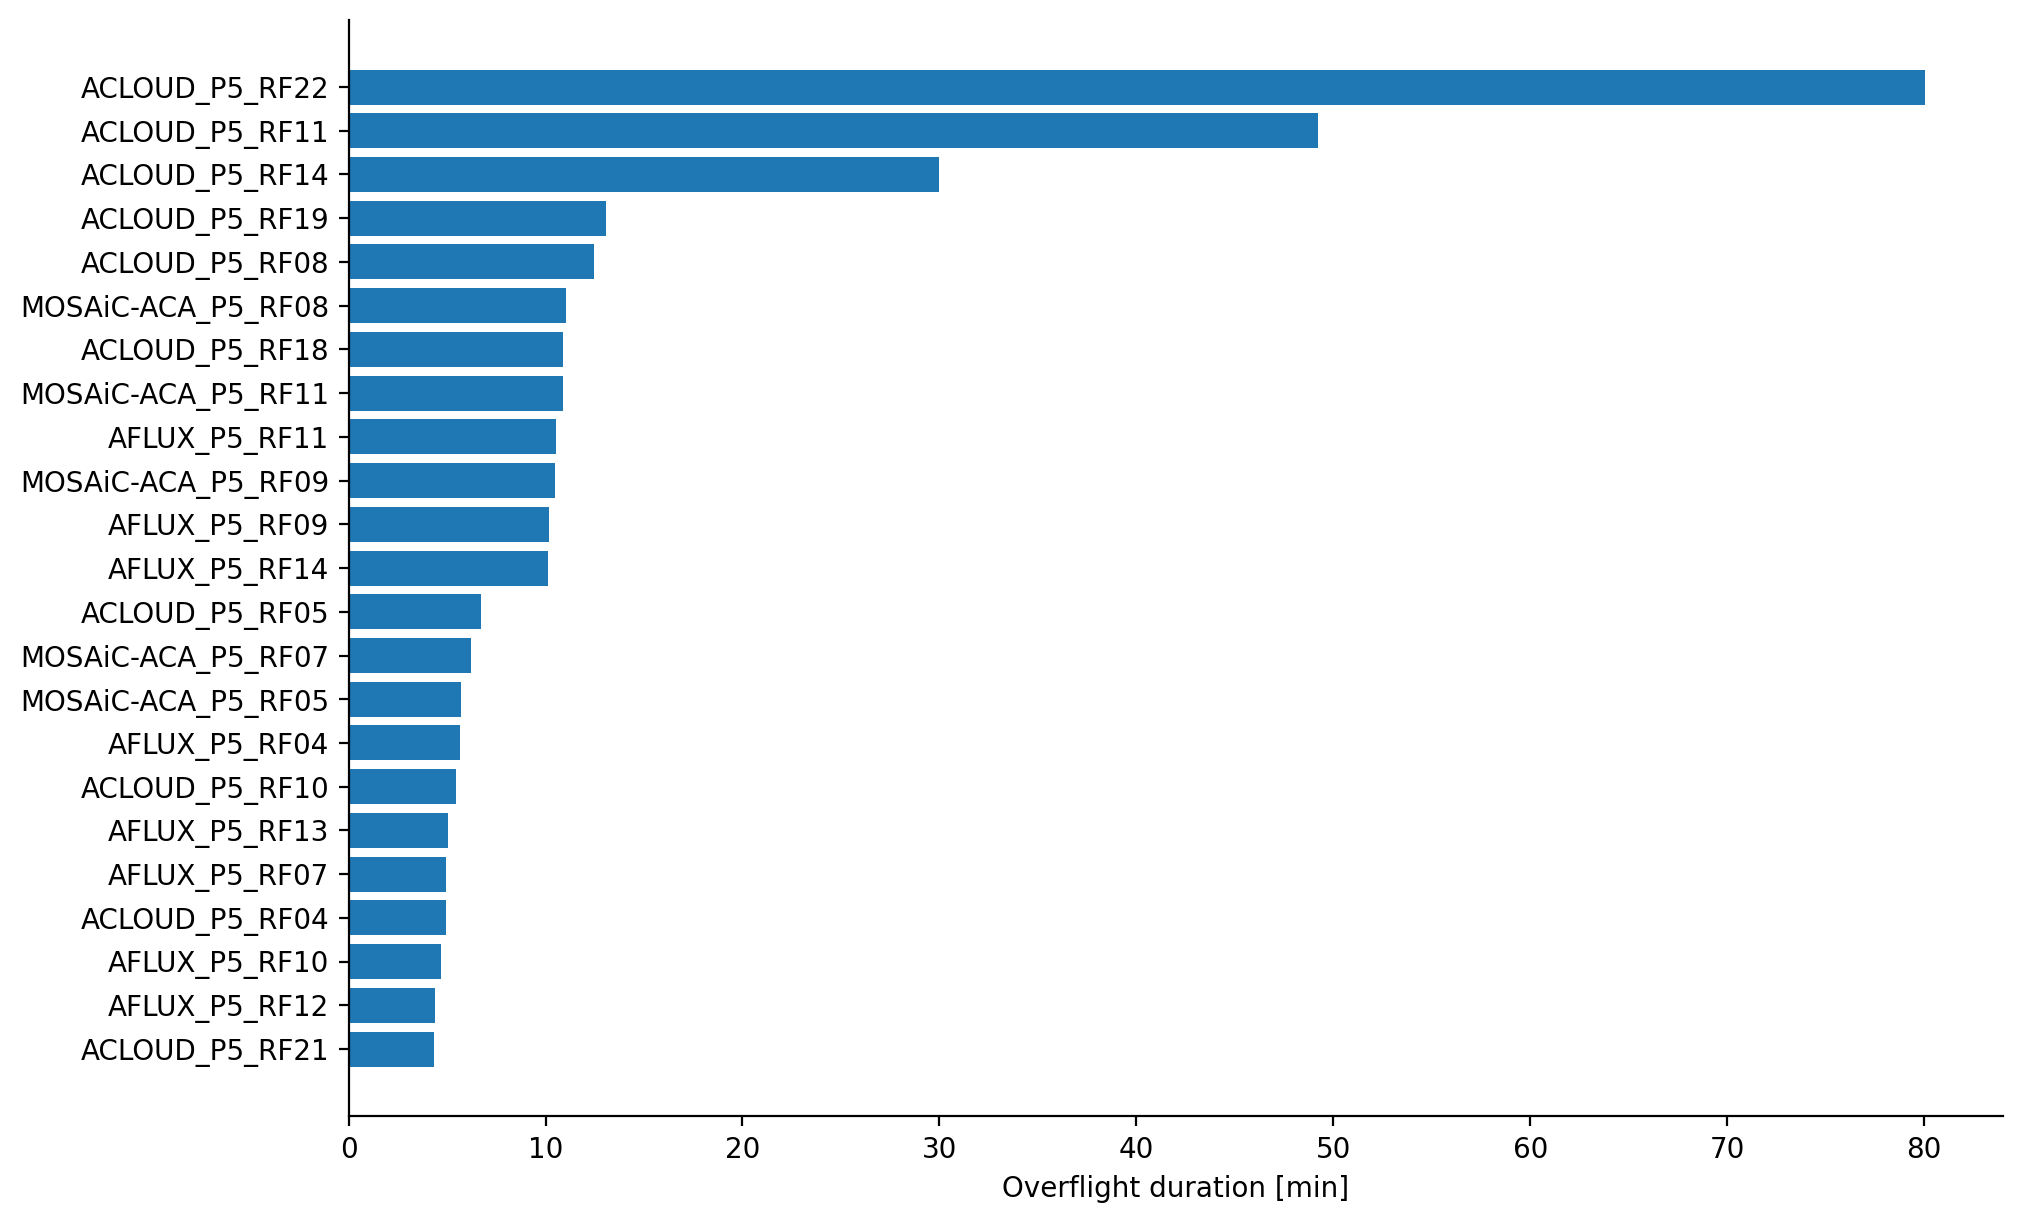

In [7]:
fig, ax = plt.subplots(1, 1)
ix = np.argsort(times_awipev)
ax.barh(flights_awipev[ix], times_awipev[ix])
ax.set_xlabel('Overflight duration [min]')
plt.show()

## Vertical cross section of overflights
Using the altitude information stored in the GPS-INS dataset, we can plot a vertical cross section of the overflights as function of distance to AWIPEV.

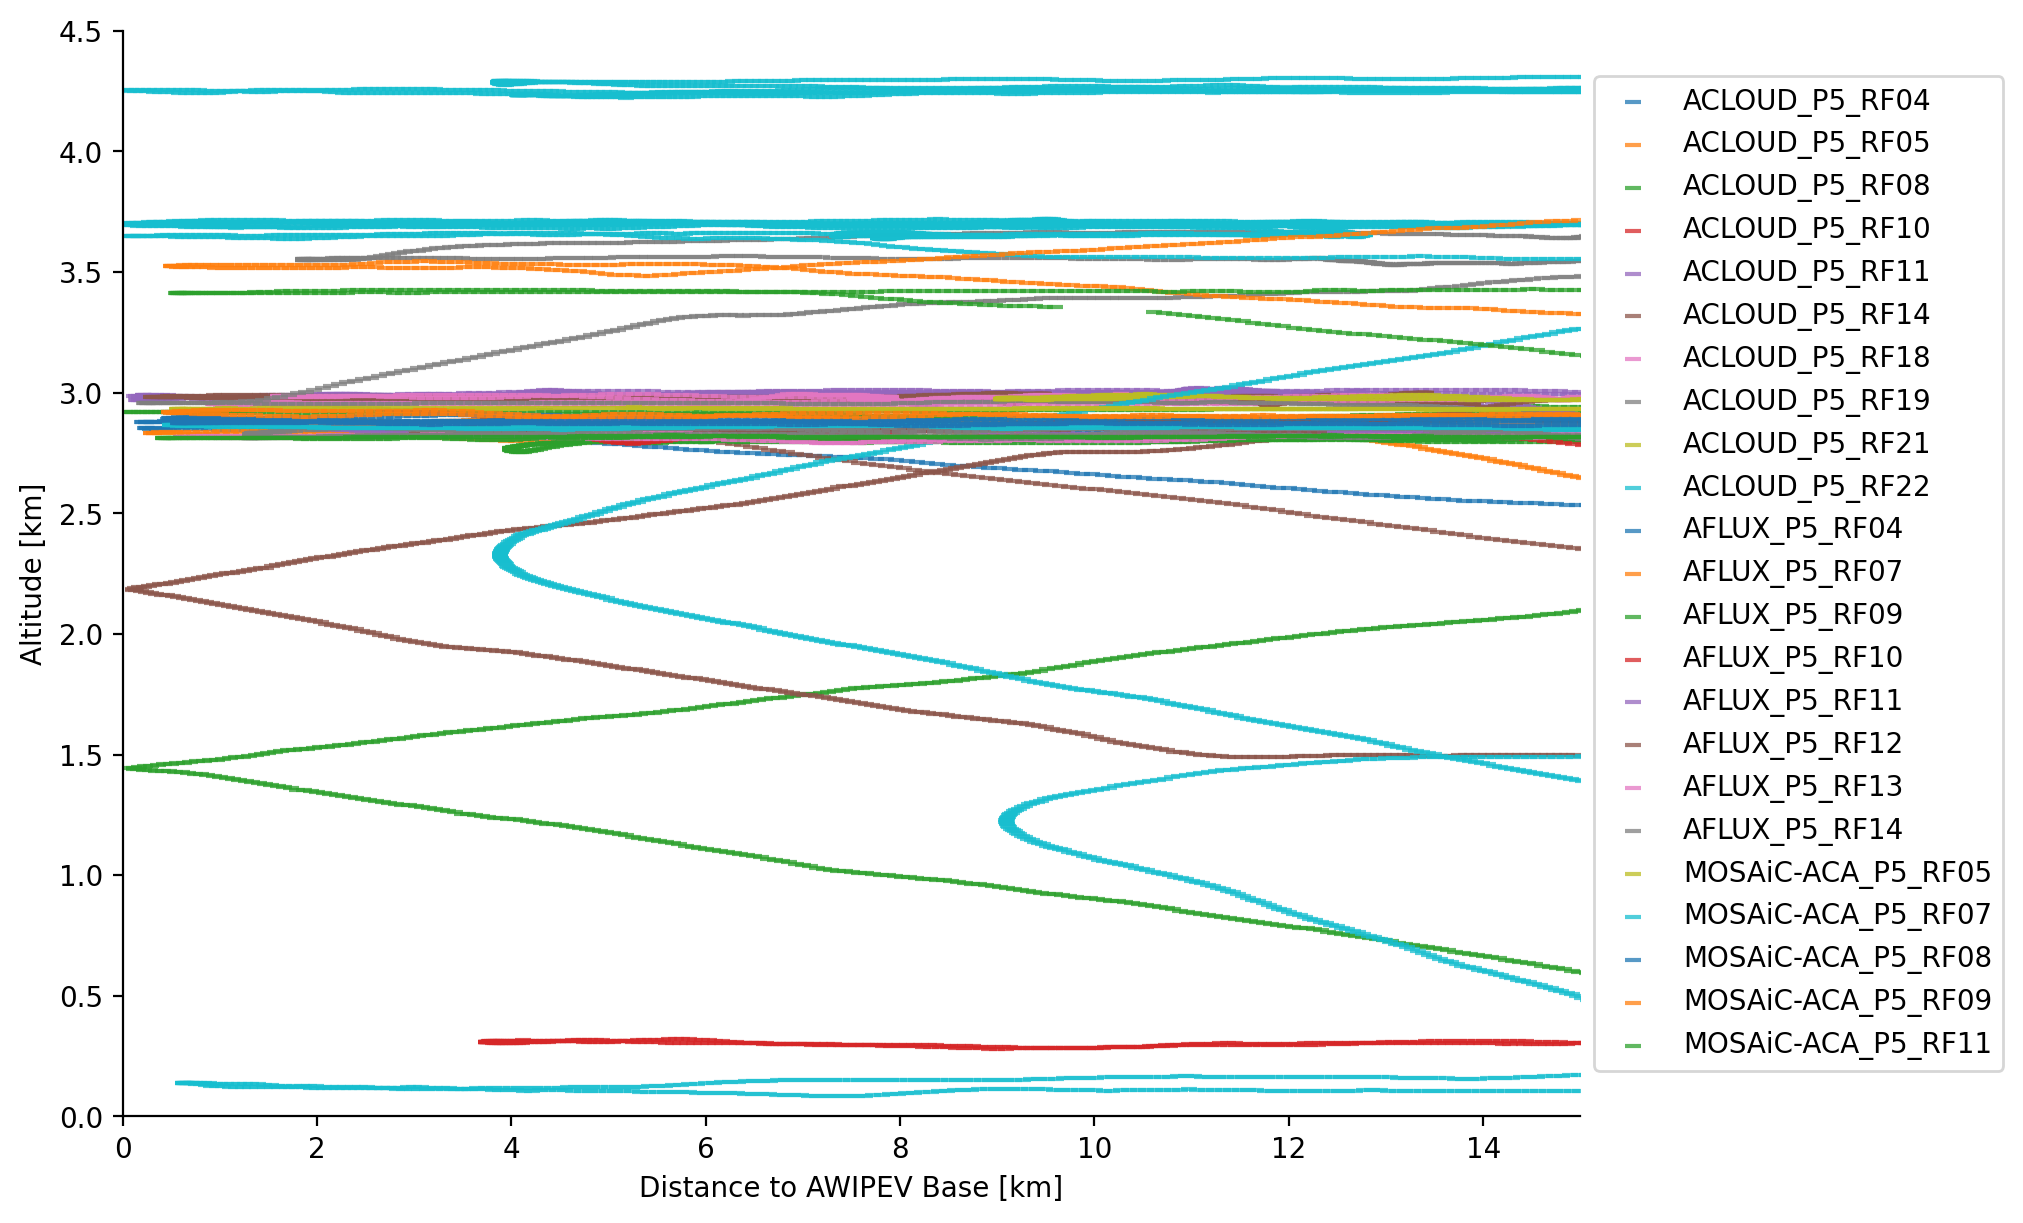

In [6]:
fig, ax = plt.subplots(1, 1)

kwargs = dict(marker='_', alpha=0.75)

for flight_id, flight in meta['P5'].items():
    
    # read gps data of flight
    ds_gps = cat['P5']['GPS_INS'][flight_id].to_dask()
        
    # calculate distance to AWIPEV
    ds_dist = dist2awipev(ds_gps)
    
    if ds_dist['dist'].min() < 15:
        
        ax.scatter(ds_dist['dist'], ds_gps['alt'].sel(time=ds_dist.time)*1e-3, label=flight_id,
                   **kwargs)

ax.set_xlim(0, 15)
ax.set_ylim(0, 4.5)

ax.set_ylabel('Altitude [km]')
ax.set_xlabel('Distance to AWIPEV Base [km]')

ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.show()